# GAN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import os

In [2]:
torch.__version__
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 数据准备

In [3]:
# 对数据进行标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

In [4]:
train_ds = torchvision.datasets.MNIST('data',
                                      train = True,
                                      transform = transform,
                                      download = True)

In [5]:
dataloader = torch.utils.data.DataLoader(train_ds, batch_size = 32, shuffle = True)

## 定义生成器
输入是长度为 100 的噪声（正太分布随机数）
输出为（1,28,28）的图片

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28),
            nn.Tanh()
        )

    def forward(self, x):             # x表示长度为100的noise输入
        img = self.main(x)
        img = img.view(-1,28,28,1)
        return img

## 定义判别器
输出为（1,28,28）的图片  输出为二分类的概率值，输出使用sigmoid激活
BCEloss计算交叉熵损失

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.main(x)
        return x

## 初始化模型、优化器及损失计算函数

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
gen = Generator().to(device)
dis = Discriminator().to(device)

In [10]:
d_optim = torch.optim.Adam(dis.parameters(), lr = 0.0001)
g_optim = torch.optim.Adam(gen.parameters(), lr = 0.0001)

In [11]:
loss_fn = torch.nn.BCELoss()

## 绘图函数

In [12]:
def gen_img_plot(model, test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize = (4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((prediction[i] + 1) / 2)
        plt.axis('off')
    plt.show()

In [13]:
test_input = torch.randn(16, 100, device = device)

## GAN的训练

In [14]:
D_loss = []
G_loss = []

Epoch: 0
g_loss tensor(2.8192, device='cuda:0')
d_loss tensor(0.3488, device='cuda:0')


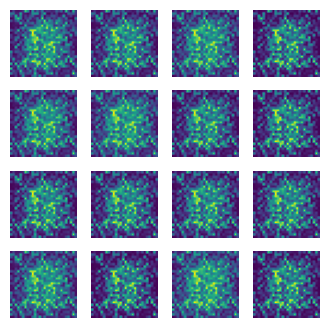

Epoch: 1
g_loss tensor(3.6055, device='cuda:0')
d_loss tensor(0.1751, device='cuda:0')


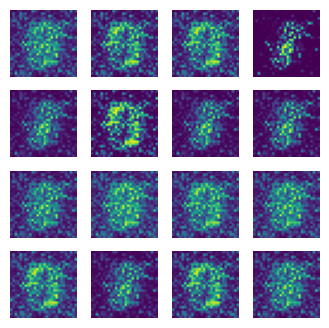

Epoch: 2
g_loss tensor(4.7170, device='cuda:0')
d_loss tensor(0.1217, device='cuda:0')


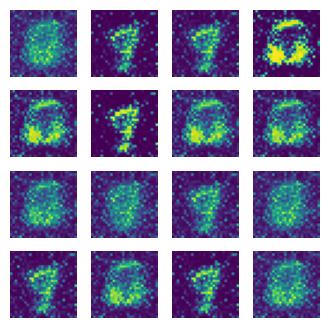

Epoch: 3
g_loss tensor(5.7401, device='cuda:0')
d_loss tensor(0.0975, device='cuda:0')


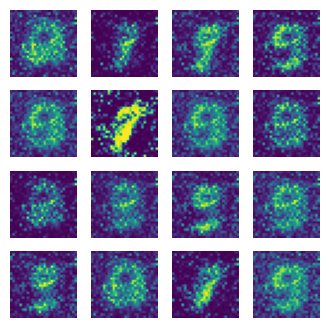

Epoch: 4
g_loss tensor(5.1581, device='cuda:0')
d_loss tensor(0.1685, device='cuda:0')


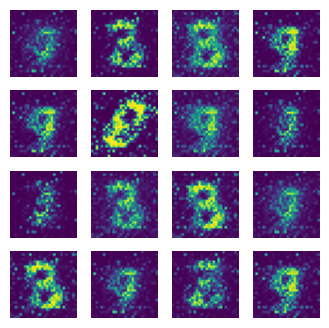

Epoch: 5
g_loss tensor(5.5887, device='cuda:0')
d_loss tensor(0.1452, device='cuda:0')


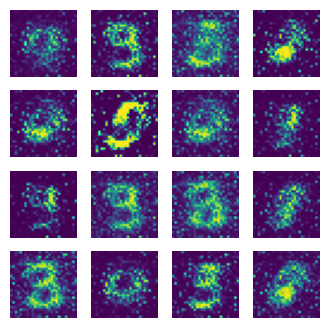

Epoch: 6
g_loss tensor(5.8248, device='cuda:0')
d_loss tensor(0.1284, device='cuda:0')


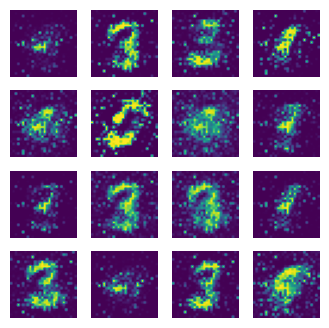

Epoch: 7
g_loss tensor(6.2899, device='cuda:0')
d_loss tensor(0.1174, device='cuda:0')


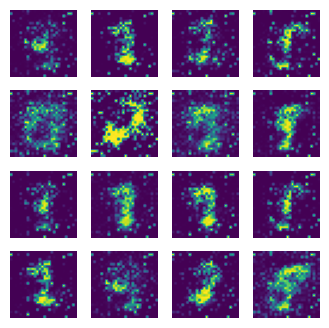

Epoch: 8
g_loss tensor(6.6992, device='cuda:0')
d_loss tensor(0.1287, device='cuda:0')


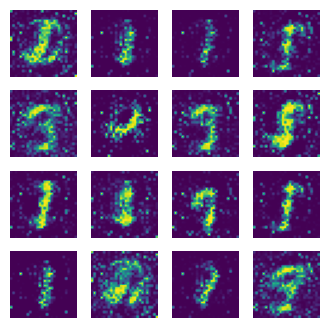

Epoch: 9
g_loss tensor(5.7525, device='cuda:0')
d_loss tensor(0.2002, device='cuda:0')


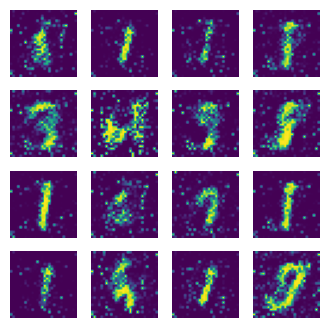

Epoch: 10
g_loss tensor(5.4054, device='cuda:0')
d_loss tensor(0.2151, device='cuda:0')


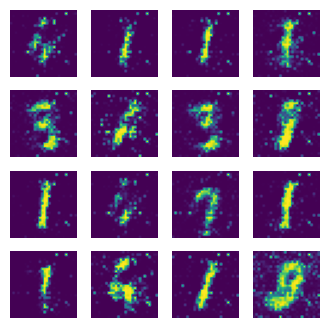

Epoch: 11
g_loss tensor(4.5526, device='cuda:0')
d_loss tensor(0.2688, device='cuda:0')


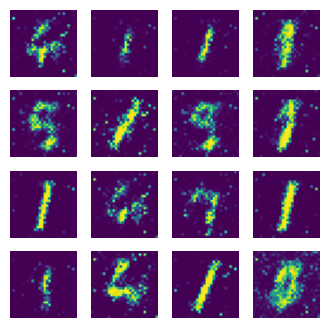

Epoch: 12
g_loss tensor(5.2504, device='cuda:0')
d_loss tensor(0.2296, device='cuda:0')


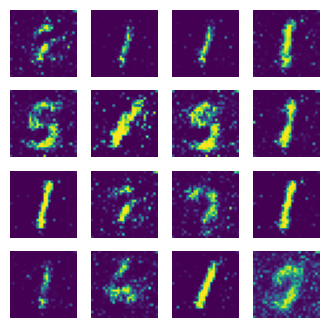

Epoch: 13
g_loss tensor(3.9043, device='cuda:0')
d_loss tensor(0.3141, device='cuda:0')


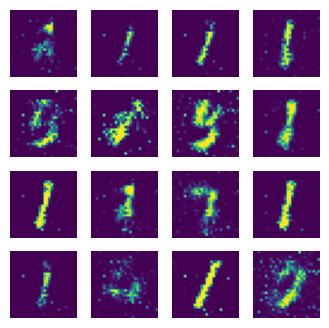

Epoch: 14
g_loss tensor(3.8259, device='cuda:0')
d_loss tensor(0.3363, device='cuda:0')


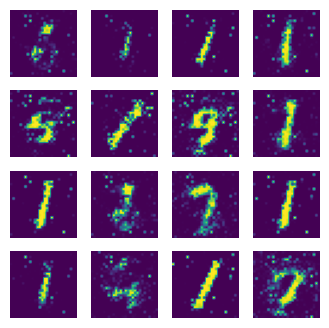

Epoch: 15
g_loss tensor(3.9545, device='cuda:0')
d_loss tensor(0.3464, device='cuda:0')


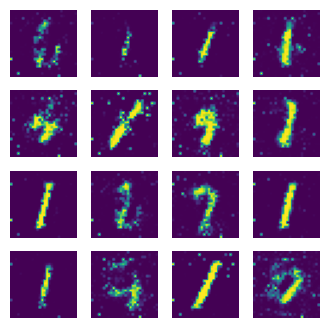

Epoch: 16
g_loss tensor(3.1259, device='cuda:0')
d_loss tensor(0.4132, device='cuda:0')


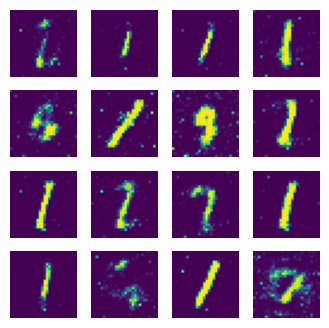

Epoch: 17
g_loss tensor(2.8250, device='cuda:0')
d_loss tensor(0.4550, device='cuda:0')


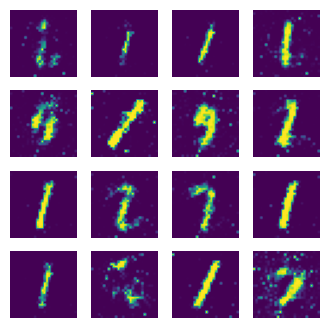

Epoch: 18
g_loss tensor(3.8232, device='cuda:0')
d_loss tensor(0.3446, device='cuda:0')


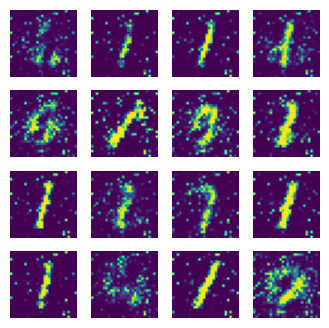

Epoch: 19
g_loss tensor(4.9194, device='cuda:0')
d_loss tensor(0.2741, device='cuda:0')


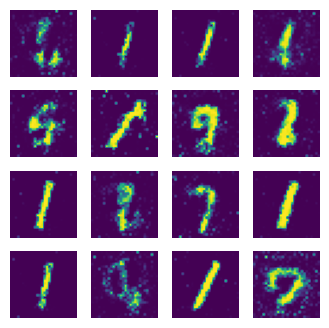

In [15]:
# 训练循环
for epoch in range(20):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)
    for step, (img, _) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size, 100, device = device)

        d_optim.zero_grad()
        real_output = dis(img)      # 判别器输入真实图片，real_optput对真实图片的预测结果
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output))        # 判别器在真实图像上的损失
        d_real_loss.backward()

        gen_img = gen(random_noise)
        fake_output = dis(gen_img.detach())      # 判别器输入生成的图片，fake_output对生成图片的预测
        d_fake_loss = loss_fn(fake_output,
                              torch.zeros_like(real_output))     # 得到判别器在生成图像的损失
        d_fake_loss.backward()

        d_loss = d_real_loss + d_fake_loss
        d_optim.step()

        g_optim.zero_grad()
        fake_output = dis(gen_img)
        g_loss = loss_fn(fake_output,
                              torch.ones_like(fake_output))     # 生成器的损失
        g_loss.backward()
        g_optim.step()

        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss

    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch:',epoch)
        print("g_loss", g_epoch_loss)
        print("d_loss", d_epoch_loss)
        gen_img_plot(gen, test_input)